In [29]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

import joblib
import torch

In [30]:
def train_test_plot(X_train, y_train, X_test, y_test, title1="Train", title2="Test"):
    plt.figure(figsize=(16, 7))

    ax = plt.subplot(121)
    plt.title(title1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    _ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

    plt.subplot(122, sharex=ax, sharey=ax)
    plt.title(title2)
    plt.xlabel("$x_1$")
    # Если классификатор предсказал вероятность принадлежности первому классу >= 0.5, считаем объект принадлежащим классу 1
    # в противном случае - 0
    _ = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y."""
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    margin_x1 = (X[:, 0].max() - X[:, 0].min()) * 0.1
    margin_x2 = (X[:, 1].max() - X[:, 1].min()) * 0.1

    x_min, x_max = X[:, 0].min() - margin_x1, X[:, 0].max() + margin_x1
    y_min, y_max = X[:, 1].min() - margin_x2, X[:, 1].max() + margin_x2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 501), np.linspace(y_min, y_max, 501))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="Set3", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="Set3", ec='black', alpha=1, lw=0.5)

    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def train_test_model_plot(model, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)

    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)

In [4]:
def get_spiral_data(N, D, K):
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    return X, y

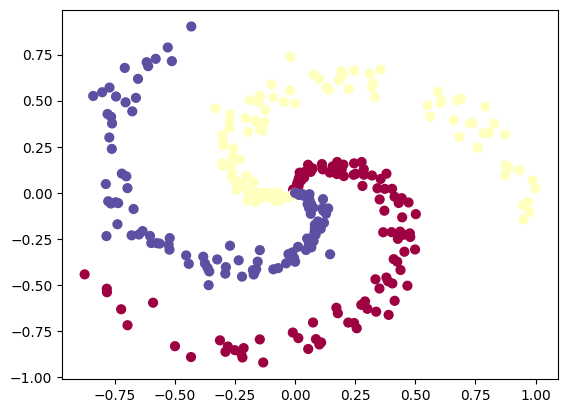

In [6]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()




In [31]:
X, y = get_spiral_data(200, 2, 3)

In [32]:
X, y = torch.Tensor(X), torch.Tensor(y)
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

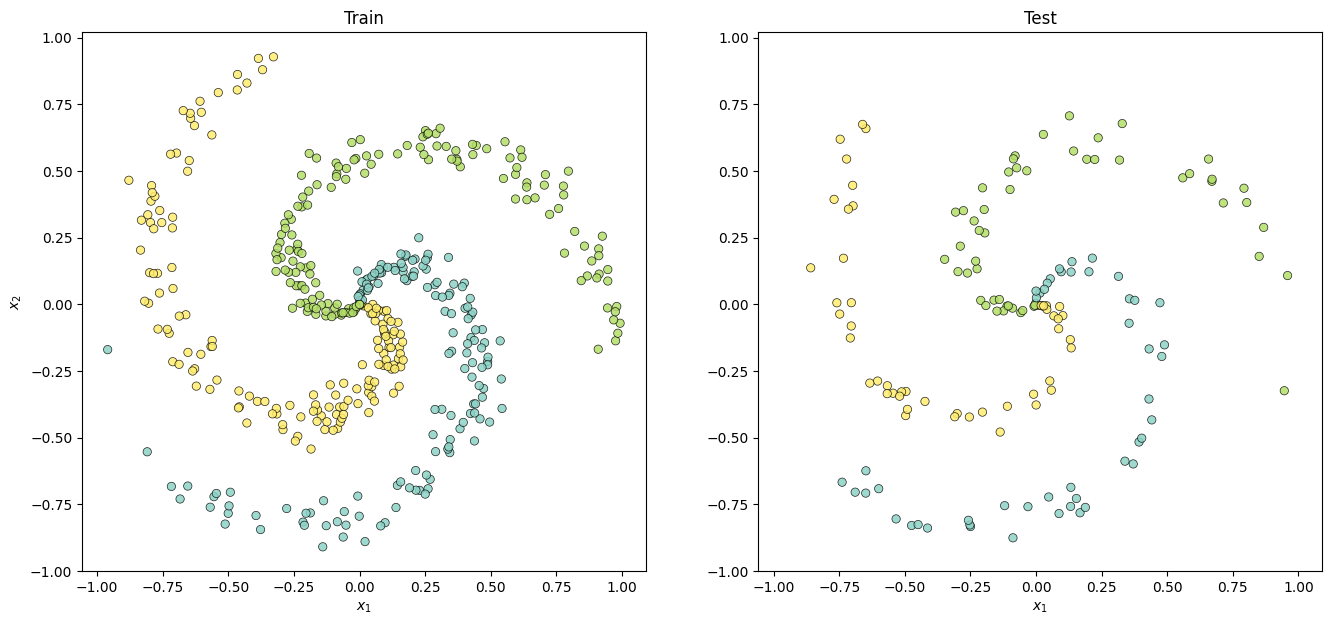

In [34]:
train_test_plot(X_train, y_train, X_test, y_test)

In [35]:
class MulticlassModelNonLinear(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_units)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_units, output_features)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


In [24]:
net

MulticlassModelNonLinear(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
net = MulticlassModelNonLinear(2, 3, 16)
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [40]:
torch.squeeze(y_train, dim=3)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 3)

In [37]:
def learn_multiclass(model, optimizer, n_epochs):
    for epoch in range(n_epochs):

        model.train()

        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim = 1)

        loss = loss_fun(y_logits, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss:.5f}")

In [28]:
learn_multiclass(net, optimizer, 10_000)

RuntimeError: expected scalar type Long but found Float